In [ ]:
# Усов Руслан Николаевич
# Тема преддипломной практики: «Разработка алгоритмов машинного обучения для обнаружения ошибок в текстах (на примере Частного образовательного учреждения высшего образования «Московский университет имени С.Ю. Витте»)»

# Первичная обработка данных, анализ

In [18]:
# Импорты
import pandas as pd
import os

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
import Levenshtein
from wordcloud import WordCloud

print(f'Библиотеки ипортированы:')
print('matplotlib', matplotlib.__version__)
print('seaborn', sns.__version__)
print('numpy', np.__version__)
print('wordcloud', pd.__version__)
print('Levenshtein')
print('Counter')


Библиотеки ипортированы:
matplotlib 3.9.2
seaborn 0.13.2
numpy 1.26.4
wordcloud 2.2.3
Levenshtein
Counter


## Объединение датасета разных файлов в один

In [7]:
# Пути к файлам
input_files = [
    "../data/raw/wikipedia.txt",
    "../data/raw/aspell.txt",
    "../data/raw/birkbeck.txt"
]

print(f'Файлы wikipedia.txt, aspell.txt и birkbeck.txt загружены')

# Парсер файлов
def parse_file(path):
    data = []
    with open(path, "r", encoding="utf-8") as file:
        for line in file:
            if ":" not in line:
                continue
            correct, typos = line.split(":", 1)
            correct = correct.strip()
            for typo in typos.strip().split():
                data.append({"correct": correct, "noisy": typo})
    return data

# Сбор всех строк из всех файлов
all_data = []
for file_path in input_files:
    if os.path.exists(file_path):
        all_data.extend(parse_file(file_path))
    else:
        print(f"Файл не найден: {file_path}")

# Преобразование в DataFrame
df = pd.DataFrame(all_data)

# Сохранение в CSV
output_path = "../data/processed/dataset.csv"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
df.to_csv(output_path, index=False, encoding="utf-8")

print(f'Датасет сформирован')

Файлы wikipedia.txt, aspell.txt и birkbeck.txt загружены
Датасет сформирован


## Загрузка датасета и формирование df

In [19]:
# Загрузка датасета и формирование df
print("Загружаем датасет...")
df = pd.read_csv("../data/processed/dataset.csv")
print(f"Загружен датасет с количеством {len(df)} строк")
df.head()

Загружаем датасет...
Загружен датасет с количеством 39119 строк


,correct,noisy
0,Apennines,Apenines
1,Apennines,Appenines
2,Athenian,Athenean
3,Athenians,Atheneans
4,Bernoulli,Bernouilli


## Формируем первичный анализ по словам

In [24]:
# Формируем первичный анализ по словам
print("Анализируем базовую статистику по датасету...")

print("Уникальных правильных слов:", df["correct"].nunique())
print("Уникальных опечаток:", df["noisy"].nunique())
print("Средняя длина правильных слов:", df["correct"].str.len().mean())
print("Средняя длина ошибочных слов:", df["noisy"].str.len().mean())

print("Анализ завершен")

Анализируем базовую статистику по датасету...
Уникальных правильных слов: 7402
Уникальных опечаток: 36108
Средняя длина правильных слов: 8.180296019836907
Средняя длина ошибочных слов: 7.702029756122501
Анализ завершен


## Построение графика зависимости длинны слов

Построение графика распределения по длинне слов...


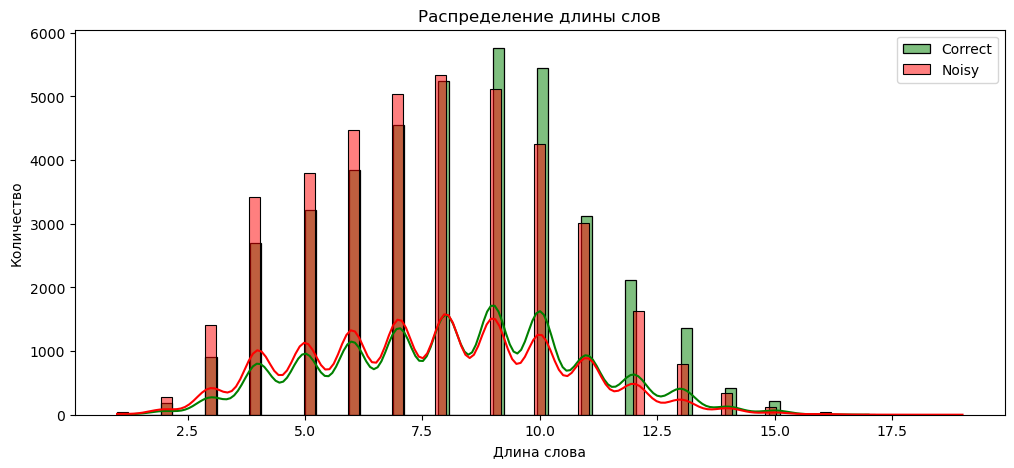

График построен


In [28]:
# Построение графика зависимости длинны слов
print("Построение графика распределения по длинне слов...")

df["correct_len"] = df["correct"].str.len()
df["noisy_len"] = df["noisy"].str.len()

plt.figure(figsize=(12, 5))
sns.histplot(df["correct_len"], color="green", label="Correct", kde=True)
sns.histplot(df["noisy_len"], color="red", label="Noisy", kde=True)
plt.title("Распределение длины слов")
plt.legend()
plt.xlabel("Длина слова")
plt.ylabel("Количество")
plt.savefig('../src/analysis-stat/len.png', dpi=300)
plt.show()

print("График построен")

## Очистка датасета

In [ ]:
# Находим данные, которые не соответствуют датасету

print("Строки, где 'correct' не строка:")
print(df[~df["correct"].apply(lambda x: isinstance(x, str))])

print("\nСтроки, где 'noisy' не строка:")
print(df[~df["noisy"].apply(lambda x: isinstance(x, str))])


Строки, где 'correct' не строка:
Empty DataFrame
Columns: [correct, noisy, correct_len, noisy_len]
Index: []

Строки, где 'noisy' не строка:
      correct noisy  correct_len  noisy_len
23240     man   NaN            3        NaN


In [ ]:

print("Фильтруем строки с некорректными значениями...")

# Фильтруем строки, где нет NaN и оба значения — строки
df_clean = df.dropna(subset=["correct", "noisy"])
df_clean = df_clean[
    df_clean["correct"].apply(lambda x: isinstance(x, str)) &
    df_clean["noisy"].apply(lambda x: isinstance(x, str))
]

print(f"Осталось строк после очистки: {len(df_clean)}")

Фильтруем строки с некорректными значениями...
Осталось строк после очистки: 39118


## Вычисляем расстояние Левенштейна

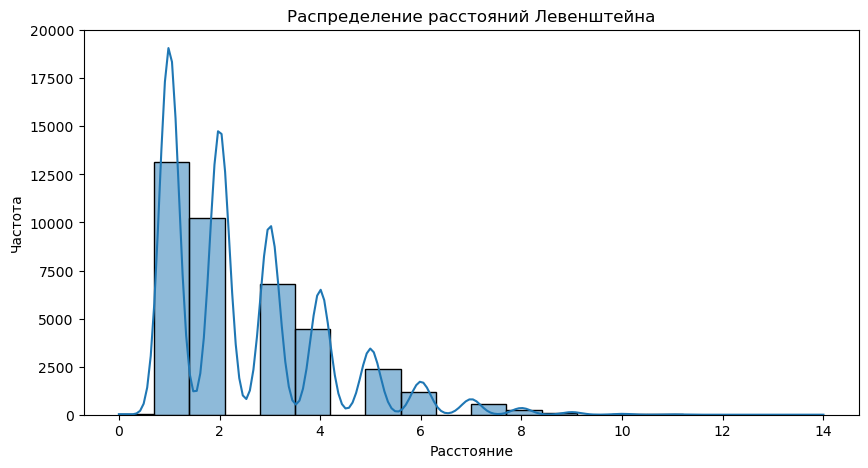

In [39]:
# Вычисляем расстояние Левенштейна
df_clean["levenshtein"] = df_clean.apply(
    lambda row: Levenshtein.distance(row["correct"], row["noisy"]), axis=1
)

# График
plt.figure(figsize=(10, 5))
sns.histplot(df_clean["levenshtein"], bins=20, kde=True)
plt.title("Распределение расстояний Левенштейна")
plt.xlabel("Расстояние")
plt.ylabel("Частота")
plt.show()

## Находим частые слова с опечатками

Самые частые опечатки...


C:\Users\Rreeo\AppData\Local\Temp\ipykernel_7576\341101537.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=common_typos.index, x=common_typos.values, palette="viridis")


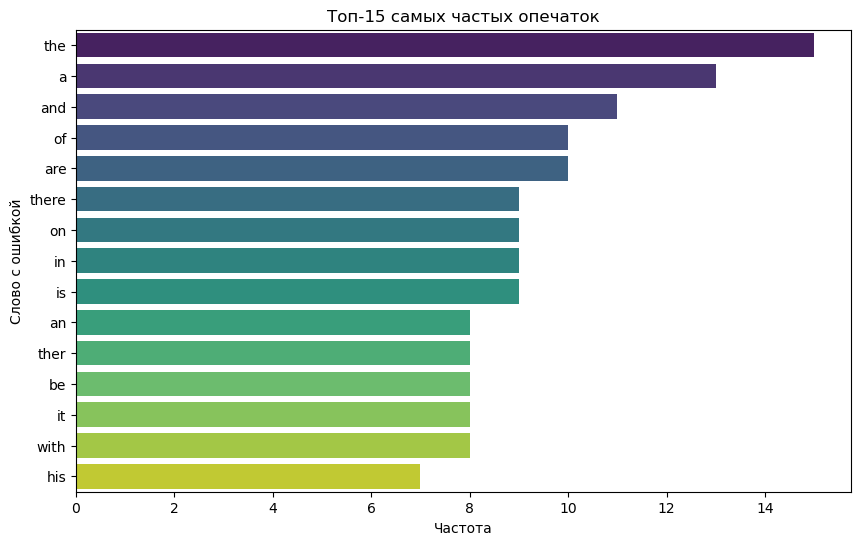

In [40]:
# Ячейка 6: Самые частые опечатки
print("Самые частые опечатки...")
common_typos = df["noisy"].value_counts().head(15)

plt.figure(figsize=(10, 6))
sns.barplot(y=common_typos.index, x=common_typos.values, palette="viridis")
plt.title("Топ-15 самых частых опечаток")
plt.xlabel("Частота")
plt.ylabel("Слово с ошибкой")
plt.show()